In [ ]:
import shutil
import random
import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import pathlib

import tensorflow as tf
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix


# Set random seed for reproducibility
seed_train_validation = 42
tf.random.set_seed(seed_train_validation)
np.random.seed(seed_train_validation)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In this cell all the paths's files are imported. Then image_size and batch_size are setted.

In [ ]:
# Directory paths
train_data_dir = '/kaggle/input/aml-flowers-dataset/train_images_by_class/train_images_by_class'
val_data_dir = '/kaggle/input/aml-flowers-dataset/validation_images_by_class/validation_images_by_class'
test_data_dir = '/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class'

# CSV file paths
train_csv_path = '/kaggle/input/aml-flowers-dataset/classes_train.csv'
val_csv_path = '/kaggle/input/aml-flowers-dataset/classes_valid.csv'
test_csv_path = '/kaggle/input/aml-flowers-dataset/classes_test.csv'

train_labels = pd.read_csv(train_csv_path)
val_labels = pd.read_csv(val_csv_path)
test_labels = pd.read_csv(test_csv_path)

# Image size
image_size = (299, 299)

# Batch size
batch_size = 64

In order to resolve the data scarsity of the train set, in this cell it was used the ImageDataGenerator function to set some parameters that will be used to do data augmentation during the fit of the model.
Furthemore, train generator is used to apply the data augmentation, and to preprocess data as the EfficientNet model requires. For the training data the shuffle parameter is setted to TRUE in order to have different batch contents.

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    brightness_range=[1-0.3, 1+0.3],
    zoom_range=[1-0.2, 1+0.2],
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed = 42
)

Found 1020 images belonging to 102 classes.


Now it's the validation and test data preprocessing. In this case it wasn't used data augmentation and the shuffle parameter is setted to FALSE.

In [ ]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 1020 images belonging to 102 classes.
Found 6149 images belonging to 102 classes.


Now it is possible to import the pre trained InceptionV3 model with weights equal to ImageNet. In particular, all the layer are now freezed with the command base_model.trainable = False.
This is the phase in which it is selected the cutting point; in this way now the model_cut is ready to use.

In [ ]:
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

base_model.trainable = False

cut_off_layer = 'conv2d_84'

model_cut = Model(inputs=base_model.input, outputs=base_model.get_layer(cut_off_layer).output)

87910968/87910968 [==============================] - 3s 0us/step


In this cell the real classification model is composed and customized in order to classify the 102 flowers categories.

In [ ]:
# Build your model
model = tf.keras.Sequential([
    model_cut,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.5),
    Dense(102),
    tf.keras.layers.Activation('softmax')
])

In [ ]:
#model.summary()

Before starting the real model training it was necessary to implement a linear learning rate scheduler to obtain the best range to use in the training with the CLR as it was written in the relative paper.

In [ ]:
class LinearLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, start_lr, end_lr, num_epochs):
        super(LinearLearningRateScheduler, self).__init__()
        self.start_lr = start_lr  # Learning rate iniziale
        self.end_lr = end_lr      # Learning rate finale
        self.num_epochs = num_epochs  # Numero totale di epoche
        self.lr_increment = (end_lr - start_lr) / (num_epochs - 1)  # Incremento per ogni epoca
        self.learning_rates = []  # Per tenere traccia dei learning rates
        self.losses = []  # Per tenere traccia delle loss

    def on_epoch_end(self, epoch, logs=None):
        # Calcola il nuovo learning rate
        new_lr = self.start_lr + (epoch * self.lr_increment)

        # Aggiorna il learning rate
        keras.backend.set_value(self.model.optimizer.lr, new_lr)

        # Registra il learning rate e la loss per questa epoca
        self.learning_rates.append(new_lr)
        self.losses.append(logs.get('loss'))  # Usa 'loss' invece di 'accuracy'

        # Stampa il learning rate per l'epoca corrente
        print(f"\nEpoch {epoch+1}: Learning rate is {new_lr:.6f}, Loss is {logs.get('loss')}.")


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])

start_lr = 1e-9
end_lr = 0.1
num_epochs = 20

linearLR = LinearLearningRateScheduler(start_lr, end_lr, num_epochs)

Per la scelta del learning rate

In [ ]:
history_linearLR = model.fit(train_generator, epochs = num_epochs, callbacks=[linearLR])

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 4.9375 - accuracy: 0.0245
Epoch 1: Learning rate is 0.000000, Loss is 4.937469482421875.
16/16 [==============================] - 40s 2s/step - loss: 4.9375 - accuracy: 0.0245
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 3.7997 - accuracy: 0.1461
Epoch 2: Learning rate is 0.005263, Loss is 3.799668550491333.
16/16 [==============================] - 26s 2s/step - loss: 3.7997 - accuracy: 0.1461
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 3.4934 - accuracy: 0.2049
Epoch 3: Learning rate is 0.010526, Loss is 3.4934308528900146.
16/16 [==============================] - 25s 2s/step - loss: 3.4934 - accuracy: 0.2049
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 2.9864 - accuracy: 0.3216
Epoch 4: Learning rate is 0.015789, Loss is 2.9864470958709717.
16/16 [==============================] - 25s 2s/step - loss: 2.9864 - accuracy: 0.3216
Epoch 5/20
16/16 [====

The plot shows the loss changes according to the learning rate.
To avoid taking too wide a range, the range from 0.005 to 0.06 was considered, which represents the one in which the loss drops the most.

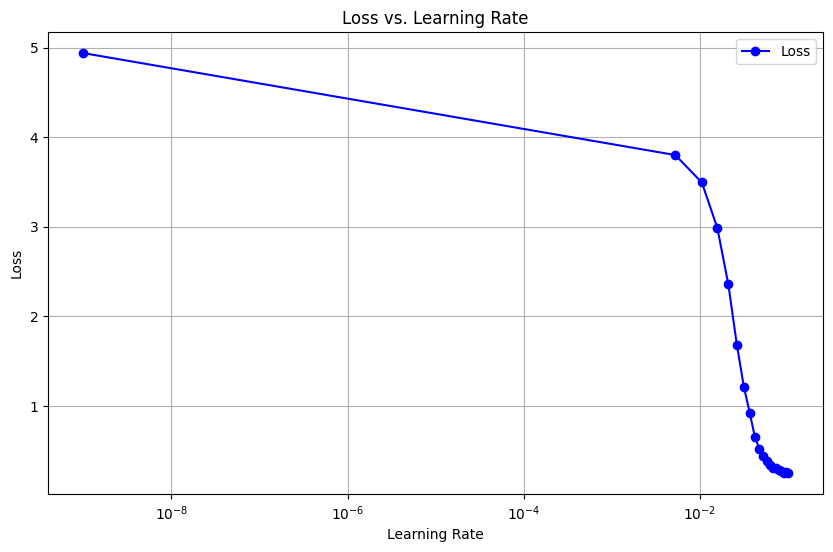

In [ ]:
# Funzione per creare il plot
def plot_lr_vs_loss(learning_rates, losses):
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, losses, marker='o', color='b', label='Loss')
    plt.title('Loss vs. Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Usa scala logaritmica per una migliore visualizzazione
    plt.show()

# Crea il plot
plot_lr_vs_loss(linearLR.learning_rates, linearLR.losses)

This cell is the Cyclic Learning Rate implementation and it was taken by the relative paper.

In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.

    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

base_model.trainable = False

cut_off_layer = 'conv2d_84'

model_cut = Model(inputs=base_model.input, outputs=base_model.get_layer(cut_off_layer).output)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Build your model
model = tf.keras.Sequential([
    model_cut,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.5),
    Dense(102),
    tf.keras.layers.Activation('softmax')
])

At this point it was possible to compile and train the model. In this phase all the pre trained model layers are not trainable.
It was used an SGD optimizer with momentum setted to 0.9.
The early stop task is to arrest the training when validation loss doesn't decrease in 5 epochs.

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])

clr = CyclicLR(base_lr=0.005, max_lr=0.06, step_size=2, mode='triangular')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data=val_generator,
    callbacks=[clr, early_stop]
)

Epoch 1/100
16/16 [==============================] - 55s 3s/step - loss: 4.6654 - accuracy: 0.0647 - val_loss: 4.3479 - val_accuracy: 0.0931
Epoch 2/100
16/16 [==============================] - 34s 2s/step - loss: 2.4467 - accuracy: 0.4000 - val_loss: 3.9719 - val_accuracy: 0.2765
Epoch 3/100
16/16 [==============================] - 34s 2s/step - loss: 1.4473 - accuracy: 0.6588 - val_loss: 3.6660 - val_accuracy: 0.4039
Epoch 4/100
16/16 [==============================] - 34s 2s/step - loss: 1.0529 - accuracy: 0.7431 - val_loss: 3.4013 - val_accuracy: 0.5863
Epoch 5/100
16/16 [==============================] - 34s 2s/step - loss: 0.7469 - accuracy: 0.8206 - val_loss: 3.1916 - val_accuracy: 0.6402
Epoch 6/100
16/16 [==============================] - 34s 2s/step - loss: 0.6275 - accuracy: 0.8461 - val_loss: 2.9596 - val_accuracy: 0.6461
Epoch 7/100
16/16 [==============================] - 35s 2s/step - loss: 0.5425 - accuracy: 0.8627 - val_loss: 2.7192 - val_accuracy: 0.7000
Epoch 8/100
1

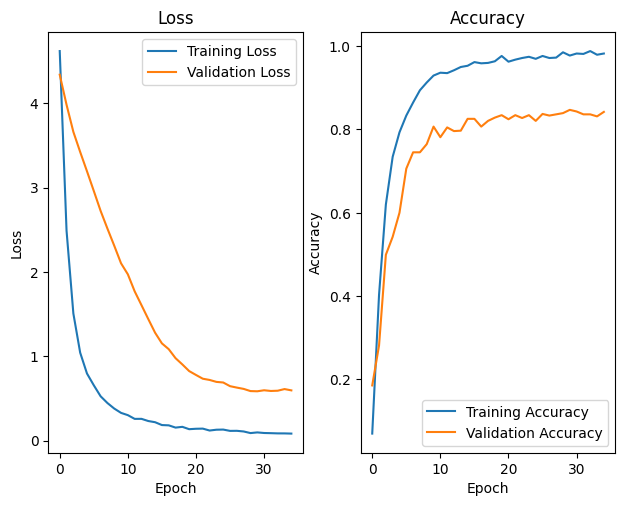

In [ ]:
def plot_performance(history):
  fig, ax = plt.subplots(1, 2)
  fig.tight_layout()
  train_acc = history.history['accuracy']
  valid_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label='Training Loss')
  ax[0].plot(valid_loss, label='Validation Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].plot(train_acc, label='Training Accuracy')
  ax[1].plot(valid_acc, label='Validation Accuracy')
  ax[1].legend()

  plt.show()

plot_performance(history)

this cell shows the performance obtained on the test set before unfreezing.

In [ ]:
# Evaluate on the test set
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

97/97 [==============================] - 93s 960ms/step - loss: 0.6209 - accuracy: 0.8333
Test loss: 0.6209056377410889
Test accuracy: 0.8333062529563904


In [ ]:
# model.save('inception_FINAL_nofreeze.keras')

In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model('/kaggle/working/inception_FINAL_nofreeze.keras')

In [ ]:
def unfreeze_model(base_model):
    # We unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in base_model.layers[:-10]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True


unfreeze_model(model_cut)

This is the second phase of training; it's important to observe that in this case it was used a fixed very low learning rate.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-9), metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_fine = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/100
16/16 [==============================] - 54s 2s/step - loss: 0.4854 - accuracy: 0.8647 - val_loss: 0.9123 - val_accuracy: 0.7480
Epoch 2/100
16/16 [==============================] - 35s 2s/step - loss: 0.1204 - accuracy: 0.9735 - val_loss: 0.6669 - val_accuracy: 0.8118
Epoch 3/100
16/16 [==============================] - 36s 2s/step - loss: 0.0801 - accuracy: 0.9863 - val_loss: 0.6367 - val_accuracy: 0.8206
Epoch 4/100
16/16 [==============================] - 36s 2s/step - loss: 0.0916 - accuracy: 0.9804 - val_loss: 0.5128 - val_accuracy: 0.8490
Epoch 5/100
16/16 [==============================] - 35s 2s/step - loss: 0.0661 - accuracy: 0.9873 - val_loss: 0.5322 - val_accuracy: 0.8510
Epoch 6/100
16/16 [==============================] - 36s 2s/step - loss: 0.0566 - accuracy: 0.9902 - val_loss: 0.4844 - val_accuracy: 0.8647
Epoch 7/100
16/16 [==============================] - 35s 2s/step - loss: 0.0527 - accuracy: 0.9863 - val_loss: 0.4629 - val_accuracy: 0.8676
Epoch 8/100
1

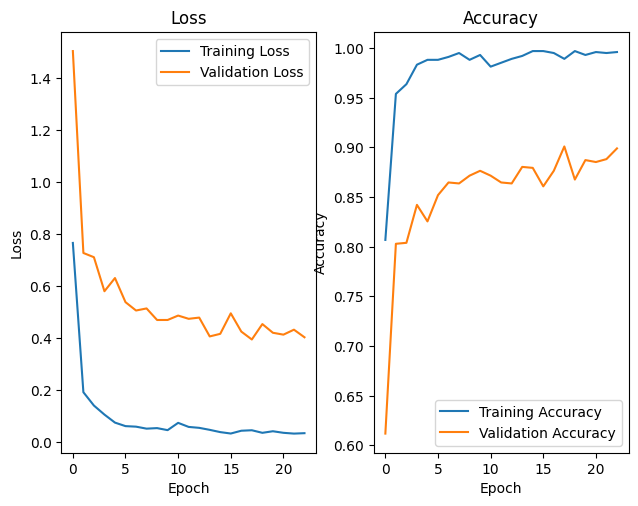

In [ ]:
def plot_performance(history):
  fig, ax = plt.subplots(1, 2)
  fig.tight_layout()
  train_acc = history.history['accuracy']
  valid_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label='Training Loss')
  ax[0].plot(valid_loss, label='Validation Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].plot(train_acc, label='Training Accuracy')
  ax[1].plot(valid_acc, label='Validation Accuracy')
  ax[1].legend()

  plt.show()

plot_performance(history_fine)

These are the performances obtained on test set after the last ten layers unfreeze.

In [ ]:
# Evaluate on the test set
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

97/97 [==============================] - 34s 347ms/step - loss: 0.5154 - accuracy: 0.8614
Test loss: 0.5153871178627014
Test accuracy: 0.861440896987915


In [ ]:
# model.save('inception_final_unfreeze.keras')
# model.save('inception_final_unfreeze.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


****Confusion matrix****

In [ ]:
# model = load_model('/kaggle/input/inception-final/inception_final_unfreeze.keras')

97/97 [==============================] - 72s 678ms/step


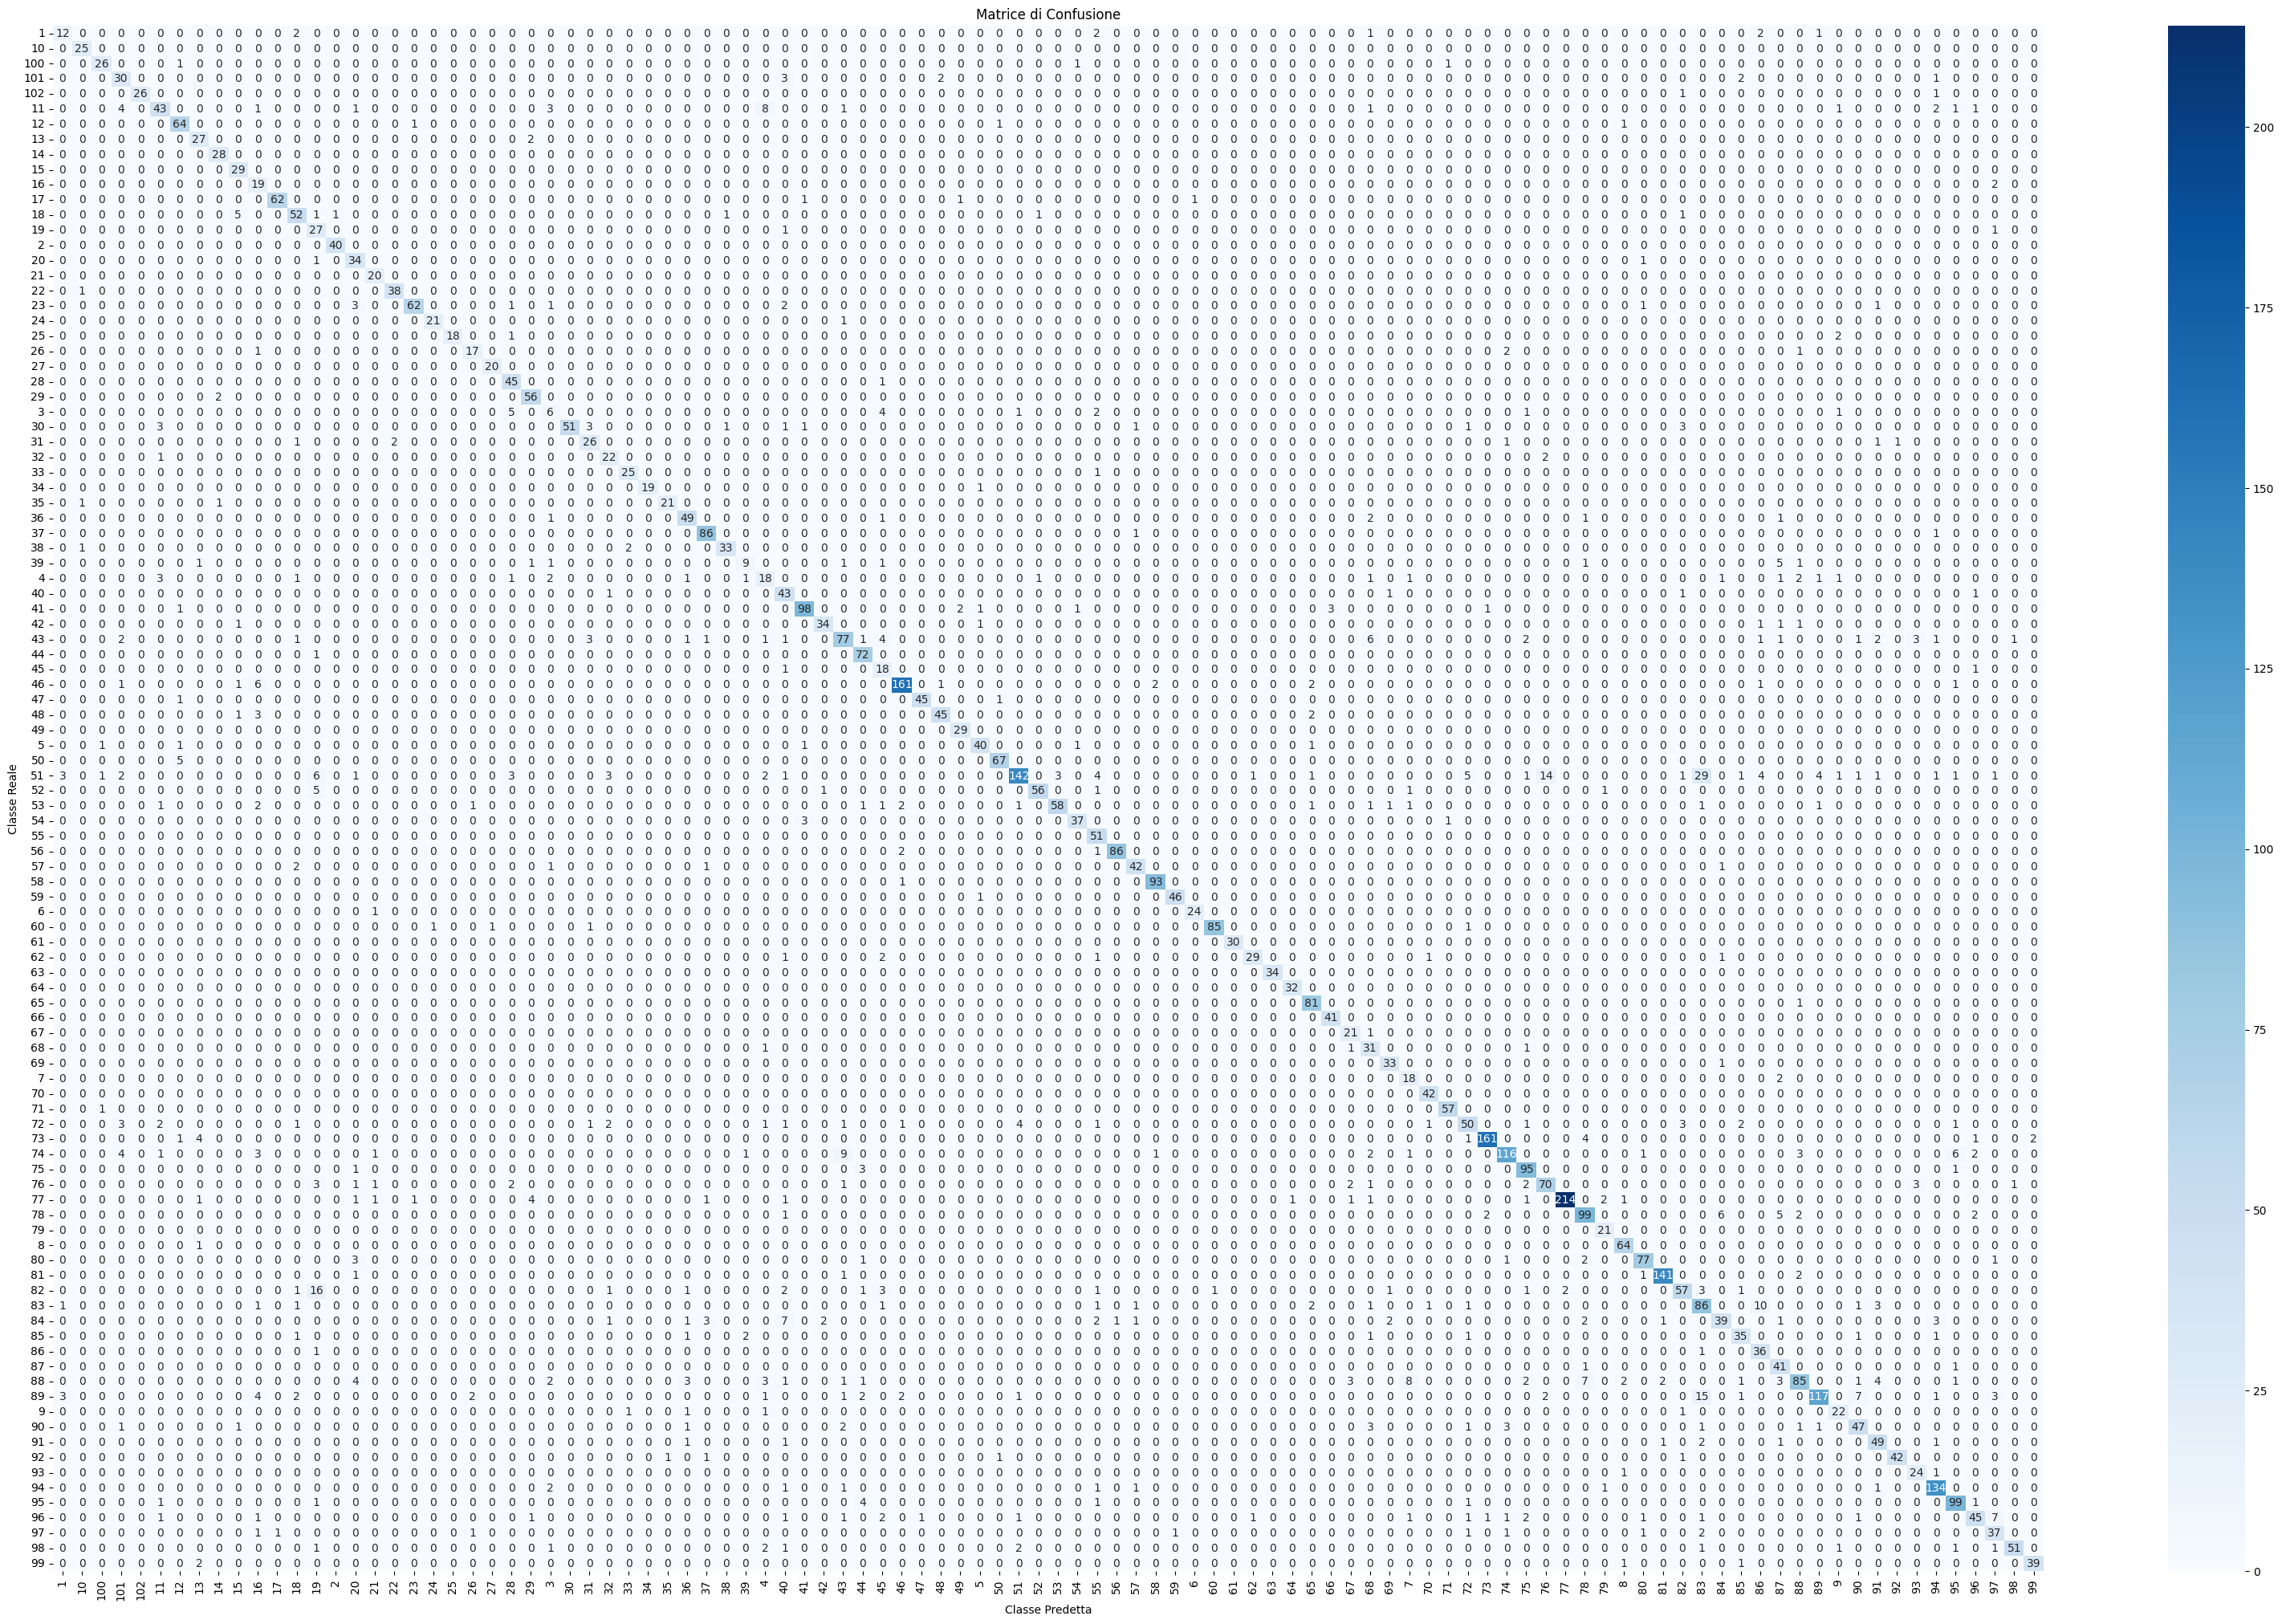

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

confusion = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(40, 25))

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
class_names = sorted(test_generator.class_indices, key=test_generator.class_indices.get)

plt.xlabel('Classe Predetta')
plt.ylabel('Classe Reale')
plt.title('Matrice di Confusione')
plt.xticks(ticks=np.arange(0.5, 102.5), labels=class_names)
plt.yticks(ticks=np.arange(0.5, 102.5), labels=class_names)

# plt.savefig('confusion_matrix.png')

plt.show()

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))

97/97 [==============================] - 33s 336ms/step
              precision    recall  f1-score   support

           1       0.63      0.60      0.62        20
          10       0.89      1.00      0.94        25
         100       0.90      0.90      0.90        29
         101       0.64      0.79      0.71        38
         102       1.00      0.93      0.96        28
          11       0.77      0.64      0.70        67
          12       0.86      0.96      0.91        67
          13       0.75      0.93      0.83        29
          14       0.90      1.00      0.95        28
          15       0.76      1.00      0.87        29
          16       0.45      0.90      0.60        21
          17       0.98      0.95      0.97        65
          18       0.80      0.84      0.82        62
          19       0.43      0.93      0.59        29
           2       0.98      1.00      0.99        40
          20       0.68      0.94      0.79        36
          21       0.83  